The dataset consists of banking information and loan defaults from Taiwan.
The goal of this work is to build classification models to predict the risk of default based on information in the dataset.
Datapoints include the amount of loan, demographics about the lender including age, sex, education, marital status and age, as well as bill amounts and repayment habits.

In [13]:
# import required modules
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [14]:
#load dataset from csv file and view header and first lines
dfraw = pd.read_csv('creditf.csv')
print('Table of credit dataset')
dfraw.head()

Table of credit dataset


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DFNM
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Details about the dataset -
Sex : 1= male, 2= female
Education: 1= grad school, 2= university, 3= HS, 4= other
Married: 1= married, 2= singe, 3= divorced
Age: integer value, age
Pay columns by month : -1 paiad on-time, 1= delay 1 month, 2= delay for 2 months, 
    8= delay for 8 months, 9= delay of 9 months and greater
Bill Amt columns: integer value, amount of payment
DFNM: default 0= no, 1= yes

In [15]:
#clean up dataset - remove ID column
dfraw=dfraw.drop(['ID'],axis=1)

In [16]:
#convert some integer columns to categorical data
dfraw['SEX'] = dfraw['SEX'].astype('category')
dfraw['EDUCATION'] = dfraw['EDUCATION'].astype('category')
dfraw['MARRIAGE'] = dfraw['MARRIAGE'].astype('category')
dfraw['PAY_0'] = dfraw['PAY_0'].astype('category')
dfraw['PAY_2'] = dfraw['PAY_2'].astype('category')
dfraw['PAY_3'] = dfraw['PAY_3'].astype('category')
dfraw['PAY_4'] = dfraw['PAY_4'].astype('category')
dfraw['PAY_5'] = dfraw['PAY_5'].astype('category')
dfraw['PAY_6'] = dfraw['PAY_6'].astype('category')
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null int64
PAY_0        30000 non-null category
PAY_2        30000 non-null category
PAY_3        30000 non-null category
PAY_4        30000 non-null category
PAY_5        30000 non-null category
PAY_6        30000 non-null category
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DFNM         30000 non-null int64
dtypes: category(9), int64(15)
memory usage: 3.7


MODELING - Payment history


Create a new dataset that separates out demographic information and focuses on loan amounts, billing amounts and payment history

In [17]:
#strip demographic information and create new dataframe with only payment information
dfnew=dfraw.iloc[:,5:24]
features = dfraw.iloc[:,5:23]
features.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [18]:
#set dependent variable 
#default? 0=no, 1=yes
depVar = dfnew['DFNM']

In [7]:
#create training set
X_train = (features[:21000])
X_train.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [8]:
#Training set
y_train = depVar[:21000]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
print(y_train.head())

The number of observations in the Y training set are: 21000
0    1
1    1
2    0
3    0
4    0
Name: DFNM, dtype: int64


In [9]:
#Test set
X_test = features[-9000:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 9000
      PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  \
21000     1    -1    -1    -1     0     0          0        780          0   
21001     2     0     0     0     0     0     178220     184848     188411   
21002     0     0     0     0     0     0     128602     118109      21557   
21003     2     0     0     0    -2    -2     160106     162743      81890   
21004     2     0     0     0     0     2      79237      65301      67253   

       BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
21000       1170        780          0       780         0      1170   
21001     191291     189029     192023     10000      9000      8000   
21002      23186      14117      15797      3203      6015      5055   
21003          0          0          0      7600      4000         0   
21004      67352      74448      72928      3000      4005      2500   

       PAY_AMT4  PAY_AMT5  PAY_AMT6

In [10]:
#Ground truth
y_test = depVar[:-9000]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 21000


0    1
1    1
2    0
3    0
4    0
Name: DFNM, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

In [12]:
X_train.shape, X_test.shape

((15750, 18), (5250, 18))

In [13]:
#Define then run models
modelSVR = SVR()
modelRF = RandomForestRegressor()
modelNB = GaussianNB()
modelKNN = KNeighborsClassifier()

In [14]:
modelRF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
modelSVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
modelNB.fit(X_train,y_train)

GaussianNB(priors=None)

In [17]:
modelKNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [18]:
#Calculate accuracy of models
print(cross_val_score(modelRF, X_train, y_train))

[0.07860211 0.12033281 0.08700464]


In [19]:
print(cross_val_score(modelSVR, X_train, y_train)) 

[-0.02299185 -0.02277646 -0.02052148]


In [20]:
print(cross_val_score(modelNB, X_train, y_train)) 

[0.364502   0.428      0.40883978]


In [21]:
print(cross_val_score(modelKNN, X_train, y_train)) 

[0.75185679 0.75085714 0.74795199]


In [22]:
#Model Fitting
modelRF.score(X_train,y_train)

0.8069569739117378

In [23]:
modelSVR.score(X_train,y_train)

0.8918645061605504

In [24]:
modelNB.score(X_train,y_train)

0.38876190476190475

In [25]:
modelKNN.score(X_train,y_train)

0.8128253968253968

In [26]:
#Select the best model to make predictions with

In [27]:
#Make Predictions
predictions = modelRF.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.086
RMSE: 0.404


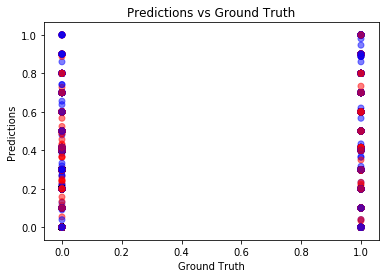

In [28]:
plt.scatter(y_test, predictions, color=['blue','red'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth')
plt.show();

Create a new dataset that separates focuses on demographic information only


MODELS - Demographic information


In [19]:
#examine only demographic information and create new dataframe
dfeatures = dfraw.iloc[:,0:5]
dfeatures.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,20000,2,2,1,24
1,120000,2,2,2,26
2,90000,2,2,2,34
3,50000,2,2,1,37
4,50000,1,2,1,57


In [20]:
#create training set
X_train = (dfeatures[:21000])
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,20000,2,2,1,24
1,120000,2,2,2,26
2,90000,2,2,2,34
3,50000,2,2,1,37
4,50000,1,2,1,57


In [21]:
#Training set
y_train = depVar[:21000]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
print(y_train.head())

The number of observations in the Y training set are: 21000
0    1
1    1
2    0
3    0
4    0
Name: DFNM, dtype: int64


In [24]:
#Test set
X_test = dfeatures[-9000:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 9000
       LIMIT_BAL SEX EDUCATION MARRIAGE  AGE
21000      30000   1         2        1   36
21001     280000   1         3        1   40
21002     260000   1         2        1   37
21003     200000   1         2        2   32
21004      80000   1         2        2   32


In [25]:
#Ground truth
y_test = depVar[:-9000]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 21000


0    1
1    1
2    0
3    0
4    0
Name: DFNM, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

In [27]:
X_train.shape, X_test.shape

((11812, 5), (3938, 5))

In [28]:
#Define then run models
modelSVRd = SVR()
modelRFd = RandomForestRegressor()
modelNBd = GaussianNB()
modelKNNd = KNeighborsClassifier()

In [29]:
modelRFd.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
modelSVRd.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
modelNBd.fit(X_train,y_train)

GaussianNB(priors=None)

In [32]:
modelKNNd.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [33]:
#Calculate accuracy of models
print(cross_val_score(modelRFd, X_train, y_train))

[-0.27383151 -0.25137274 -0.2476941 ]


In [34]:
print(cross_val_score(modelSVRd, X_train, y_train))

[-0.14499168 -0.13676601 -0.16322278]


In [35]:
print(cross_val_score(modelNBd, X_train, y_train))

[0.77044185 0.77038354 0.77038354]


In [36]:
print(cross_val_score(modelKNNd, X_train, y_train))

[0.7277806  0.73329947 0.72694945]


In [38]:
#Model Fitting
modelRFd.score(X_train,y_train)

0.4453959501772464

In [39]:
modelSVRd.score(X_train,y_train)

0.1303694808066661

In [40]:
modelNBd.score(X_train,y_train)

0.7704029800203184

In [41]:
modelKNNd.score(X_train,y_train)

0.7913139180494413

In [42]:
#Select the best model to make predictions with

In [48]:
#Make Predictions
predictions = modelKNNd.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: -0.536
RMSE: 0.517
